tgb - 5/3/2021 - Load climate-invariant versions of models with and without output rescaling and see which one performs best in terms of MSE in the different climate

Steps:
- Load models with or without output rescaling  
- Code np and tf layers to interpolate back and forth from/to quantile space  
- Evaluate MSE for pre vs post processing

# Imports

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *
from scipy.interpolate import interp1d
from scipy import interp

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Load data

## Distributions

In [9]:
pathPKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA'

In [5]:
quantile_array = np.linspace(0,1,1001)

In [6]:
path_array = [
    '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
    '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
]

In [7]:
pdf = {}
hf.close()

In [10]:
for ipath,path in enumerate(path_array):
    hf = open(pathPKL+'/'+path+'_PERC.pkl','rb')
    pdf[path] = pickle.load(hf)

In [11]:
pdf

{'2021_03_18_O3_TRAIN_M4K_shuffle.nc': {'quantile_array': array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
  'PERC_array': array([[9.05374009e-07, 8.77815637e-07, 4.98417307e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.11630138e-07, 8.91066577e-07, 5.24233712e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.13556164e-07, 8.93629931e-07, 5.24234508e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.81165069e-06, 1.79016258e-06, 1.61611712e-06, ...,
          4.71056754e-05, 4.42048546e-05, 8.29813011e-05],
         [1.81427470e-06, 1.79245058e-06, 1.62005475e-06, ...,
          6.76648574e-05, 7.45083865e-05, 1.28348825e-04],
         [1.82074757e-06, 1.80071015e-06, 1.63516086e-06, ...,
          5.01840608e-04, 5.79330081e-04, 6.49507623e-04]])},
 '2021_03_18_O3_TRAIN_P4K_shuffle.nc': {'quantile_array': array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
  'PERC_a

# Create data generators for all three cases

## Global Variables

In [12]:
# Load coordinates (just pick any file from the climate model run)

# Comet path below
# coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
#                     decode_times=False)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [13]:
# Comet path below
# TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
# path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'

# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

New Data generator class for the climate-invariant network. Calculates the physical rescalings needed to make the NN climate-invariant

## Data Generators

### Choose between aquaplanet and realistic geography here

In [36]:
# GP paths below
#path_aquaplanet = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
#path_realgeography = ''

# GP /fast paths below
path_aquaplanet = '/fast/tbeucler/climate_invariant/aquaplanet/'

# Comet paths below
# path_aquaplanet = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
# path_realgeography = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

path = path_aquaplanet

### Data Generator using RH

In [15]:
#scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling_2.pkl')
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','QRL','QRS']

# New GP path below
TRAINFILE_RH = '2021_01_24_O3_small_shuffle.nc'
NORMFILE_RH = '2021_02_01_NORM_O3_RH_small.nc'
    
# Comet/Ankitesh path below
# TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
# NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
# VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [16]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using QSATdeficit

We only need the norm file for this generator as we are solely using it as an input to determine the right normalization for the combined generator

In [17]:
# New GP path below
TRAINFILE_QSATdeficit = '2021_02_01_O3_QSATdeficit_small_shuffle.nc'
NORMFILE_QSATdeficit = '2021_02_01_NORM_O3_QSATdeficit_small.nc'

In [18]:
in_vars_QSATdeficit = ['QSATdeficit','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_QSATdeficit = ['PHQ','TPHYSTND','QRL','QRS']

In [19]:
train_gen_QSATdeficit = DataGenerator(
    data_fn = path+TRAINFILE_QSATdeficit,
    input_vars = in_vars_QSATdeficit,
    output_vars = out_vars_QSATdeficit,
    norm_fn = path+NORMFILE_QSATdeficit,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using TNS

In [20]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_TNS = '2021_02_01_O3_TfromNS_small_shuffle.nc'
NORMFILE_TNS = '2021_02_01_NORM_O3_TfromNS_small.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [21]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using BCONS

In [22]:
in_vars = ['QBP','BCONS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_BCONS = '2021_02_01_O3_BCONS_small_shuffle.nc'
NORMFILE_BCONS = '2021_02_01_NORM_O3_BCONS_small.nc'

In [23]:
train_gen_BCONS = DataGenerator(
    data_fn = path+TRAINFILE_BCONS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_BCONS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using NSto220

In [24]:
in_vars = ['QBP','T_NSto220','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_T_NSto220 = '2021_03_31_O3_T_NSto220_small.nc'
NORMFILE_T_NSto220 = '2021_03_31_NORM_O3_T_NSto220_small.nc'

In [25]:
train_gen_T_NSto220 = DataGenerator(
    data_fn = path+TRAINFILE_T_NSto220,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_T_NSto220,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsDELQ

In [26]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsDELQ = '2021_02_01_O3_LHF_nsDELQ_small_shuffle.nc'
NORMFILE_LHF_nsDELQ = '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [27]:
train_gen_LHF_nsDELQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsDELQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsDELQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsQ

In [234]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsQ = '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'
NORMFILE_LHF_nsQ = '2021_02_01_NORM_O3_LHF_nsQ_small.nc'

In [235]:
train_gen_LHF_nsQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator Combined (latest flexible version)

In [256]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
#if path==path_aquaplanet: out_vars=['PHQPERC','TPHYSTNDPERC','QRLPERC','QRSPERC']
out_vars = ['PHQ','TPHYSTND','QRL','QRS']

In [257]:
# TRAINFILE = '2021_01_24_O3_TRAIN_shuffle.nc'
NORMFILE = '2021_01_24_NORM_O3_small.nc'
# VALIDFILE = '2021_01_24_O3_VALID.nc'
# GENTESTFILE = 'CI_SP_P4K_valid.nc'

# In physical space
TRAINFILE = '2021_03_18_O3_TEST_M4K.nc'
#TRAINFILE_shuffle = '2021_03_18_O3_TRAIN_M4K_shuffle.nc'
VALIDFILE = '2021_03_18_O3_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_03_18_O3_TEST_P4K.nc'
TESTFILE_DIFFCLIMATE_shuffle = '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
TESTFILE_DIFFGEOG = '2021_04_18_RG_TRAIN_M4K.nc'

# In percentile space
#TRAINFILE = '2021_04_09_PERC_TRAIN_M4K_shuffle.nc'
#TRAINFILE = '2021_01_24_O3_small_shuffle.nc'
#VALIDFILE = '2021_04_09_PERC_VALID_M4K.nc'
#TESTFILE = '2021_04_09_PERC_TEST_P4K.nc'

In [231]:
for ipath,path in enumerate([TRAINFILE,VALIDFILE,TESTFILE_DIFFCLIMATE]):
    hf = open(pathPKL+'/'+path+'_PERC.pkl','rb')
    pdf[path] = pickle.load(hf)

## Brute-force

In [258]:
path = path_aquaplanet

In [259]:
train_gen_BF = DataGeneratorCI(data_fn = path+TRAINFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling=None,
                               Tscaling=None,
                               LHFscaling=None,
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=None,
                               inp_div_Qscaling=None,
                               inp_sub_Tscaling=None,
                               inp_div_Tscaling=None,
                               inp_sub_LHFscaling=None,
                               inp_div_LHFscaling=None,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

test_diffclimate_gen_BF = DataGeneratorCI(data_fn = path+TESTFILE_DIFFCLIMATE,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling=None,
                                       Tscaling=None,
                                       LHFscaling=None,
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=None,
                                       inp_div_Qscaling=None,
                                       inp_sub_Tscaling=None,
                                       inp_div_Tscaling=None,
                                       inp_sub_LHFscaling=None,
                                       inp_div_LHFscaling=None,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

# test_diffgeog_gen_BF = DataGeneratorCI(data_fn = path+TESTFILE_DIFFGEOG,
#                                        input_vars=in_vars,
#                                        output_vars=out_vars,
#                                        norm_fn=path+NORMFILE,
#                                        input_transform=('mean', 'maxrs'),
#                                        output_transform=scale_dict,
#                                        batch_size=8192,
#                                        shuffle=True,
#                                        xarray=False,
#                                        var_cut_off=None, 
#                                        Qscaling=None,
#                                        Tscaling=None,
#                                        LHFscaling=None,
#                                        SHFscaling=None,
#                                        output_scaling=False,
#                                        interpolate=False,
#                                        hyam=hyam,hybm=hybm,
#                                        inp_sub_Qscaling=None,
#                                        inp_div_Qscaling=None,
#                                        inp_sub_Tscaling=None,
#                                        inp_div_Tscaling=None,
#                                        inp_sub_LHFscaling=None,
#                                        inp_div_LHFscaling=None,
#                                        inp_sub_SHFscaling=None,
#                                        inp_div_SHFscaling=None,
#                                        lev=None, interm_size=40,
#                                        lower_lim=6,is_continous=True,Tnot=5,
#                                        epsQ=1e-3,epsT=1,mode='train')

## Input but not output rescaled (T=BCONS)

In [260]:
Tscaling_name = 'BCONS'
train_gen_T = train_gen_BCONS

train_gen_I = DataGeneratorCI(data_fn = path+TRAINFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling='RH',
                               Tscaling=Tscaling_name,
                               LHFscaling='LHF_nsDELQ',
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                               inp_div_Qscaling=train_gen_RH.input_transform.div,
                               inp_sub_Tscaling=train_gen_T.input_transform.sub,
                               inp_div_Tscaling=train_gen_T.input_transform.div,
                               inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                               inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

valid_gen_I = DataGeneratorCI(data_fn = path+VALIDFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling='RH',
                               Tscaling=Tscaling_name,
                               LHFscaling='LHF_nsDELQ',
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                               inp_div_Qscaling=train_gen_RH.input_transform.div,
                               inp_sub_Tscaling=train_gen_T.input_transform.sub,
                               inp_div_Tscaling=train_gen_T.input_transform.div,
                               inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                               inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

test_diffclimate_gen_I = DataGeneratorCI(data_fn = path+TESTFILE_DIFFCLIMATE,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling='RH',
                                       Tscaling=Tscaling_name,
                                       LHFscaling='LHF_nsDELQ',
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                                       inp_div_Qscaling=train_gen_RH.input_transform.div,
                                       inp_sub_Tscaling=train_gen_T.input_transform.sub,
                                       inp_div_Tscaling=train_gen_T.input_transform.div,
                                       inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                                       inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

# test_diffgeog_gen_I = DataGeneratorCI(data_fn = path+TESTFILE_DIFFGEOG,
#                                        input_vars=in_vars,
#                                        output_vars=out_vars,
#                                        norm_fn=path+NORMFILE,
#                                        input_transform=('mean', 'maxrs'),
#                                        output_transform=scale_dict,
#                                        batch_size=8192,
#                                        shuffle=True,
#                                        xarray=False,
#                                        var_cut_off=None, 
#                                        Qscaling='RH',
#                                        Tscaling=Tscaling_name,
#                                        LHFscaling='LHF_nsDELQ',
#                                        SHFscaling=None,
#                                        output_scaling=False,
#                                        interpolate=False,
#                                        hyam=hyam,hybm=hybm,
#                                        inp_sub_Qscaling=train_gen_RH.input_transform.sub,
#                                        inp_div_Qscaling=train_gen_RH.input_transform.div,
#                                        inp_sub_Tscaling=train_gen_T.input_transform.sub,
#                                        inp_div_Tscaling=train_gen_T.input_transform.div,
#                                        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
#                                        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
#                                        inp_sub_SHFscaling=None,
#                                        inp_div_SHFscaling=None,
#                                        lev=None, interm_size=40,
#                                        lower_lim=6,is_continous=True,Tnot=5,
#                                        epsQ=1e-3,epsT=1,mode='train')

## Input and output rescaled (T=BCONS)

In [261]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars=['PHQPERC','TPHYSTNDPERC','QRLPERC','QRSPERC']

In [262]:
# TRAINFILE = '2021_01_24_O3_TRAIN_shuffle.nc'
NORMFILE = '2021_01_24_NORM_O3_small.nc'
# VALIDFILE = '2021_01_24_O3_VALID.nc'
# GENTESTFILE = 'CI_SP_P4K_valid.nc'

# In percentile space
TRAINFILE = '2021_04_09_PERC_TEST_M4K.nc'
VALIDFILE = '2021_04_09_PERC_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_04_09_PERC_TEST_P4K.nc'
TESTFILE_DIFFGEOG = '2021_04_24_RG_PERC_TRAIN_M4K_shuffle.nc'

In [263]:
Tscaling_name = 'BCONS'
train_gen_T = train_gen_BCONS

train_gen_IO = DataGeneratorCI(data_fn = path+TRAINFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=None,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling='RH',
                               Tscaling=Tscaling_name,
                               LHFscaling='LHF_nsDELQ',
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                               inp_div_Qscaling=train_gen_RH.input_transform.div,
                               inp_sub_Tscaling=train_gen_T.input_transform.sub,
                               inp_div_Tscaling=train_gen_T.input_transform.div,
                               inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                               inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

test_diffclimate_gen_IO = DataGeneratorCI(data_fn = path+TESTFILE_DIFFCLIMATE,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=None,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling='RH',
                                       Tscaling=Tscaling_name,
                                       LHFscaling='LHF_nsDELQ',
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                                       inp_div_Qscaling=train_gen_RH.input_transform.div,
                                       inp_sub_Tscaling=train_gen_T.input_transform.sub,
                                       inp_div_Tscaling=train_gen_T.input_transform.div,
                                       inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                                       inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

# test_diffgeog_gen_IO = DataGeneratorCI(data_fn = path+TESTFILE_DIFFGEOG,
#                                        input_vars=in_vars,
#                                        output_vars=out_vars,
#                                        norm_fn=path+NORMFILE,
#                                        input_transform=('mean', 'maxrs'),
#                                        output_transform=None,
#                                        batch_size=8192,
#                                        shuffle=True,
#                                        xarray=False,
#                                        var_cut_off=None, 
#                                        Qscaling='RH',
#                                        Tscaling=Tscaling_name,
#                                        LHFscaling='LHF_nsDELQ',
#                                        SHFscaling=None,
#                                        output_scaling=False,
#                                        interpolate=False,
#                                        hyam=hyam,hybm=hybm,
#                                        inp_sub_Qscaling=train_gen_RH.input_transform.sub,
#                                        inp_div_Qscaling=train_gen_RH.input_transform.div,
#                                        inp_sub_Tscaling=train_gen_T.input_transform.sub,
#                                        inp_div_Tscaling=train_gen_T.input_transform.div,
#                                        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
#                                        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
#                                        inp_sub_SHFscaling=None,
#                                        inp_div_SHFscaling=None,
#                                        lev=None, interm_size=40,
#                                        lower_lim=6,is_continous=True,Tnot=5,
#                                        epsQ=1e-3,epsT=1,mode='train')

# Load models for all three cases

## Load models

In [243]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [244]:
# Model's path
path_BF = ['2021_04_26_MLR.hdf5','2021_04_26_NN.hdf5']
path_I = ['2021_04_26_MLR_RH_BCONS_LHF_nsDELQ.hdf5','2021_04_26_NN_RH_BCONS_LHF_nsDELQ.hdf5']
path_IO = ['2021_04_26_LOGI_PERC_RH_BCONS_LHF_nsDELQ.hdf5','2021_04_26_NN_PERC_RH_BCONS_LHF_nsDELQ.hdf5']

In [245]:
NN = load_model(path_HDF5+path_BF[1],compile=False)
NN_I = load_model(path_HDF5+path_I[1],compile=False)
NN_IO = load_model(path_HDF5+path_IO[1],compile=False)

## Develop functions to go between physical and quantile space

In [189]:
#pdf

In [190]:
pdf_m4K = pdf['2021_03_18_O3_TRAIN_M4K_shuffle.nc']
pdf_p4K = pdf['2021_03_18_O3_TRAIN_P4K_shuffle.nc']
pdf_RG = pdf['2021_04_18_RG_TRAIN_M4K_shuffle.nc']

### QM as pre-processing: Going back to physical space

In [177]:
model = NN_IO
train_gen_m4K = train_gen_IO
train_gen_p4K = test_diffclimate_gen_IO

model_I = NN_I
train_gen_m4K_I = train_gen_I
train_gen_p4K_I = test_diffclimate_gen_I

In [160]:
train_gen = train_gen_m4K

inp = train_gen[ib][0]
tru = train_gen[ib][1]
prd = model.predict_on_batch(inp)

In [178]:
train_gen = train_gen_m4K_I

inpI = train_gen[ib][0]
truI = train_gen[ib][1]
prdI = model_I.predict_on_batch(inpI)

In [36]:
# Valid for aquaplanet only
i0 = {}
i0['PHQ'] = 94
i0['TPHYSTND'] = 124
i0['QRL'] = 154
i0['QRS'] = 184

scale_dict0 = scale_dict['PHQ']
scale_dict0 = np.concatenate((scale_dict0,scale_dict['TPHYSTND'],scale_dict['QRL'],scale_dict['QRS']))

In [164]:
pdf_m4K['PERC_array'].shape

(1001, 214)

In [171]:
pdf_m4K['PERC_array'][:,i0['PHQ']:].shape

(1001, 120)

In [172]:
prd.shape

(8192, 120)

In [227]:
# Project onto 1D percentile space to form the output
tru_physical = np.zeros(prd.shape) # Initialization
prd_physical = np.zeros(prd.shape)
for ilev in range(prd.shape[1]):
    print('Interpolating level ',ilev,'out of ',prd.shape[1])
    interp_fx = interp1d(x=quantile_array,y=pdf_m4K['PERC_array'][:,i0['PHQ']+ilev],bounds_error=False)
    tru_physical[:,ilev] = interp_fx(tru[:,ilev])
    prd_physical[:,ilev] = interp_fx(prd[:,ilev])
tru_physical *= scale_dict0
prd_physical *= scale_dict0

Interpolating level  0 out of  120
Interpolating level  1 out of  120
Interpolating level  2 out of  120
Interpolating level  3 out of  120
Interpolating level  4 out of  120
Interpolating level  5 out of  120
Interpolating level  6 out of  120
Interpolating level  7 out of  120
Interpolating level  8 out of  120
Interpolating level  9 out of  120
Interpolating level  10 out of  120
Interpolating level  11 out of  120
Interpolating level  12 out of  120
Interpolating level  13 out of  120
Interpolating level  14 out of  120
Interpolating level  15 out of  120
Interpolating level  16 out of  120
Interpolating level  17 out of  120
Interpolating level  18 out of  120
Interpolating level  19 out of  120
Interpolating level  20 out of  120
Interpolating level  21 out of  120
Interpolating level  22 out of  120
Interpolating level  23 out of  120
Interpolating level  24 out of  120
Interpolating level  25 out of  120
Interpolating level  26 out of  120
Interpolating level  27 out of  120
In

In [228]:
np.mean((prdI-truI)**2)

170.12730761628038

In [229]:
np.mean((prd_physical-tru_physical)**2)

1003.6718589436348

In [230]:
np.mean((prd_physical-truI)**2)

1003.6718589687545

In [287]:
np.mean((tru_physical-truI)**2)

2.510537095311309e-08

In [286]:
tru_physical = quantile_to_physical(tru,pdf_m4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

### QM as post-processing: Going to percentile space

In [259]:
# Project onto 1D percentile space to form the output
truI_quantile = np.zeros(prd.shape) # Initialization
prdI_quantile = np.zeros(prd.shape)
for ilev in range(prd.shape[1]):
    print('Interpolating level ',ilev,'out of ',prd.shape[1])
    interp_fx = interp1d(x=pdf_m4K['PERC_array'][:,i0['PHQ']+ilev],y=quantile_array,bounds_error=False,fill_value=(0,1))
    truI_quantile[:,ilev] = interp_fx(truI[:,ilev]/scale_dict0[ilev])
    prdI_quantile[:,ilev] = interp_fx(prdI[:,ilev]/scale_dict0[ilev])

Interpolating level  0 out of  120
Interpolating level  1 out of  120
Interpolating level  2 out of  120
Interpolating level  3 out of  120
Interpolating level  4 out of  120
Interpolating level  5 out of  120
Interpolating level  6 out of  120
Interpolating level  7 out of  120
Interpolating level  8 out of  120
Interpolating level  9 out of  120
Interpolating level  10 out of  120
Interpolating level  11 out of  120
Interpolating level  12 out of  120
Interpolating level  13 out of  120
Interpolating level  14 out of  120
Interpolating level  15 out of  120
Interpolating level  16 out of  120
Interpolating level  17 out of  120
Interpolating level  18 out of  120
Interpolating level  19 out of  120
Interpolating level  20 out of  120
Interpolating level  21 out of  120
Interpolating level  22 out of  120
Interpolating level  23 out of  120
Interpolating level  24 out of  120
Interpolating level  25 out of  120
Interpolating level  26 out of  120
Interpolating level  27 out of  120
In

In [285]:
np.mean((tru-truI_quantile)**2)

0.0

In [266]:
np.mean((tru-prd)**2)

0.025491540315767947

In [267]:
np.mean((truI_quantile-prdI_quantile)**2)

0.0757695836803891

In [284]:
truI_quantile = physical_to_quantile(truI,pdf_m4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

### Make functions to go back and forth

In [48]:
def physical_to_quantile(output_physical,pdf_output,quantile_array,scaling_output):
    output_quantile = np.zeros(output_physical.shape)
    for ilev in range(prd.shape[1]):
        print('Interpolating level ',ilev,'out of ',output_physical.shape[1],'       ',end='\r')
        interp_fx = interp1d(x=pdf_output[:,ilev],y=quantile_array,bounds_error=False,fill_value=(0,1))
        output_quantile[:,ilev] = interp_fx(output_physical[:,ilev]/scaling_output[ilev])
    return output_quantile

In [49]:
def quantile_to_physical(output_quantile,pdf_output,quantile_array,scaling_output):
    output_physical = np.zeros(output_quantile.shape)
    for ilev in range(output_quantile.shape[1]):
        print('Interpolating level ',ilev,'out of ',output_physical.shape[1],'       ',end='\r')
        interp_fx = interp1d(x=quantile_array,y=pdf_output[:,ilev],bounds_error=False)
        output_physical[:,ilev] = interp_fx(output_quantile[:,ilev])
    output_physical *= scaling_output
    return output_physical

### Test the pre/post-QM on the generalization set

There are 5 predictions in physical space and 3 in quantile space:     
- 1+1) BF, direct prediction in physical/quantile spaces    
- 2) BF with QM-post-processing, prediction in physical space    
- 3+2) Inputs rescaling only, direct prediction in physical and quantile spaces   
- 4) Input rescalings only with QM post-processing in physical space      
- 5+3) Input+Output rescalings, in physical and quantile space   

In [330]:
ib = 450

#### 1+1) BF, direct prediction in physical and quantile space

In [331]:
inp = test_diffclimate_gen_BF[ib][0]
tru = test_diffclimate_gen_BF[ib][1]
prd = NN.predict_on_batch(inp)

In [332]:
np.mean((tru-prd)**2)

2269.139955947895

In [333]:
prd_quantile = physical_to_quantile(prd,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
tru_quantile = physical_to_quantile(tru,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

In [334]:
np.mean((tru_quantile-prd_quantile)**2)

0.11345305207715686

#### 2) BF with QM as post-processing

In [335]:
prd_quantile_m4K = physical_to_quantile(prd,pdf_m4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

In [336]:
prd_QM = quantile_to_physical(prd_quantile_m4K,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

In [337]:
np.mean((tru-prd_QM)**2)

6999.374964910534

#### 3+2) Input rescaling, direct prediction in physical and quantile space

In [338]:
inpI = test_diffclimate_gen_I[ib][0]
truI = test_diffclimate_gen_I[ib][1]
prdI = NN_I.predict_on_batch(inpI)

In [339]:
np.mean((truI-prdI)**2)

581.3297725177895

In [340]:
prdI_quantile = physical_to_quantile(prdI,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
truI_quantile = physical_to_quantile(truI,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

In [341]:
np.mean((truI_quantile-prdI_quantile)**2)

0.07917119206492841

#### 4) Input rescaling with QM as post-processing

In [342]:
prdI_quantile_m4K = physical_to_quantile(prdI,pdf_m4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

In [343]:
prdI_QM = quantile_to_physical(prdI_quantile_m4K,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

In [344]:
np.mean((truI-prdI_QM)**2)

546.9603251451517

#### 5+3) Input + output rescaling in physical and quantile space

In [346]:
inpIO = test_diffclimate_gen_IO[ib][0]
truIO = test_diffclimate_gen_IO[ib][1]
prdIO = NN_IO.predict_on_batch(inpIO)

In [347]:
np.mean((truIO-prdIO)**2)

0.04083318682668868

In [348]:
prdIO_physical = quantile_to_physical(prdIO,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
truIO_physical = quantile_to_physical(truIO,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)

In [349]:
np.mean((prdIO_physical-truIO_physical)**2)

1987.2422070075286

## Directly compare NN with and without output rescaling in cold and warm climate to understand how it influences performance & generalization abilities

In [264]:
# Valid for aquaplanet only
i0 = {}
i0['PHQ'] = 94
i0['TPHYSTND'] = 124
i0['QRL'] = 154
i0['QRS'] = 184

scale_dict0 = scale_dict['PHQ']
scale_dict0 = np.concatenate((scale_dict0,scale_dict['TPHYSTND'],scale_dict['QRL'],scale_dict['QRS']))

In [290]:
Nbatches = 125
b_random = np.random.choice(np.linspace(0,5700,5701),size=((Nbatches,)),replace=False).astype('int')
iout = 48

In [291]:
b_random

array([3628, 3757, 4996, 5208, 2198, 3871, 1941, 5409,  859,  573, 2804,
        286, 4891, 5344, 3115, 1253, 4405,  779, 4561, 2782, 4034, 4535,
       2886, 2653, 1434, 5545, 4689, 4896,  429, 5120, 4249, 3192, 2414,
       4139, 1332, 1027, 2811, 3980, 2999, 2623, 4532, 3954, 3712, 4098,
       1146,   85, 3175, 2852, 2537, 4155, 3984, 3625, 2390,  807, 4000,
        729, 1317, 3697,  756, 3256,  301,   90, 3967, 3490,   62, 1211,
        351, 5278, 5177,  106, 1548, 3981,  356, 3455, 1672, 4401, 3059,
       4753, 1060, 3259, 1804, 5578, 2967, 2597, 2144, 5560, 3596,  518,
       1279, 1177, 1380, 2229, 5340, 5246, 2609, 2034, 5636,    9, 4050,
       1839, 4622, 4573, 3982, 2449, 5400, 3934, 3053, 1093,  881, 3840,
       1144, 4260, 4415, 1786, 4940, 1584, 2329, 4371, 1547, 4930, 1495,
       1053, 1862, 4372,  333])

In [292]:
MSE = {}
INP = {}
VAR = {}
MSE_map = {}
VAR_map = {}
PRD_map = {}

In [293]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    MSE[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {}; 
    MSE_map[dataset] = {}; VAR_map[dataset] = {}; PRD_map[dataset] = {};
    
    for itype,modeltype in enumerate(['BF','I','IO','IQM']):
        print ('itype=',itype,' & modeltype=',modeltype)
            
        if modeltype=='I' or modeltype=='IQM':
            model = NN_I
            if dataset=='AQ-4K': train_gen = train_gen_I
            elif dataset=='AQ+4K': train_gen = test_diffclimate_gen_I
            elif dataset=='RG': train_gen = test_diffgeog_gen_I
        elif modeltype=='BF':
            model = NN
            if dataset=='AQ-4K': train_gen = train_gen_BF
            elif dataset=='AQ+4K': train_gen = test_diffclimate_gen_BF
        elif modeltype=='IO':
            model = NN_IO
            if dataset=='AQ-4K': train_gen = train_gen_IO
            elif dataset=='AQ+4K': train_gen = test_diffclimate_gen_IO
            elif dataset=='RG': train_gen = test_diffgeog_gen_IO
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)

            if modeltype=='IQM' and dataset=='AQ+4K':
                prdI_quantile_m4K = physical_to_quantile(prd,pdf_m4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
                prd = quantile_to_physical(prdI_quantile_m4K,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
            elif modeltype=='IO':
                if dataset=='AQ-4K':
                    prd = quantile_to_physical(prd,pdf_m4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
                    tru = quantile_to_physical(tru,pdf_m4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
                elif dataset=='AQ+4K':
                    prd = quantile_to_physical(prd,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
                    tru = quantile_to_physical(tru,pdf_p4K['PERC_array'][:,i0['PHQ']:],quantile_array,scale_dict0)
                    
#                 # Bias-correcting IO
#                 ISO_IO = np.argsort(prd,axis=1)
#                 prd = ISO_IO-np.min(ISO_IO.flatten())/(np.max(ISO_IO.flatten())-np.min(ISO_IO.flatten()))
#                 #PDF_IO = np.histogram(a=PRD_IO.flatten(),bins=100,density=True)
                
            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
            tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

            mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
            var = np.expand_dims(np.var(tru_geo,axis=2),axis=2)
            
            if ibatch==0:
                MSE[dataset][modeltype] = mse; 
                VAR[dataset][modeltype] = var; 
                INP[dataset][modeltype] = inp_geo;
                MSE_map[dataset][modeltype] = (tru_geo[:,:,[iout]]-prd_geo[:,:,[iout]])**2;
                VAR_map[dataset][modeltype] = tru_geo[:,:,[iout]]
                PRD_map[dataset][modeltype] = prd_geo[:,:,[iout]]
            else:
                MSE[dataset][modeltype] = np.concatenate((MSE[dataset][modeltype],mse),axis=2)
                VAR[dataset][modeltype] = np.concatenate((VAR[dataset][modeltype],var),axis=2)
                INP[dataset][modeltype] = np.concatenate((INP[dataset][modeltype],inp_geo),axis=3)
                MSE_map[dataset][modeltype] = np.concatenate((MSE_map[dataset][modeltype],
                                                             (tru_geo[:,:,[iout]]-prd_geo[:,:,[iout]])**2),
                                                             axis=2)
                VAR_map[dataset][modeltype] = np.concatenate((VAR_map[dataset][modeltype],
                                                             tru_geo[:,:,[iout]]),axis=2)
                PRD_map[dataset][modeltype] = np.concatenate((PRD_map[dataset][modeltype],
                                                             prd_geo[:,:,[iout]]),axis=2)

idataset= 0  & dataset= AQ-4K
itype= 0  & modeltype= BF
itype= 1  & modeltype= I3332
itype= 2  & modeltype= IO332
itype= 3  & modeltype= IQMut of  120        out of  120         120        120        120         120                 120        out of  120                120        out of  120         120        120                120         out of  120                        120                out of  120        120         120        120        120        out of  120         120                      out of  120        120                                120                out of  120         120                       out of  120         out of  120               out of  120        12 out of  120         120        out of  120         out of  120        
idataset= 1  & dataset= AQ+4K
itype= 0  & modeltype= BF
itype= 1  & modeltype= I3332
itype= 2  & modeltype= IO332
itype= 3  & modeltype= IQMut of  120        120        out of  120        120         out of  120        6 out of  120    

In [294]:
R2_map = {}
PDF_map = {}
PDF_tru = {}

In [295]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    R2_map[dataset] = {};
    PDF_map[dataset] = {};
    PDF_tru[dataset] = np.histogram(a=VAR_map[dataset][modeltype].flatten(),bins=100,density=True)
    
    for itype,modeltype in enumerate(['BF','I','IO','IQM']):
        print ('itype=',itype,' & modeltype=',modeltype)
        R2_map[dataset][modeltype] = 1-np.mean(MSE_map[dataset][modeltype],axis=2)/\
        np.var(VAR_map[dataset][modeltype],axis=2)
        PDF_map[dataset][modeltype] = np.histogram(a=PRD_map[dataset][modeltype].flatten(),bins=100,density=True)
        print('Av R2=',np.mean(R2_map[dataset][modeltype]),
              'bc av MSE_SH=',np.mean(MSE_map[dataset][modeltype]),
             'and av VAR=',np.mean(VAR_map[dataset][modeltype]))

idataset= 0  & dataset= AQ-4K
itype= 0  & modeltype= BF
Av R2= 0.6822133587575914 bc av MSE_SH= 417.04133899879474 and av VAR= -1.604433727125843
itype= 1  & modeltype= I
Av R2= 0.7263954347708719 bc av MSE_SH= 409.7658223765494 and av VAR= -1.604433727125843
itype= 2  & modeltype= IO
Av R2= -14.793227194424077 bc av MSE_SH= 16558.39700483227 and av VAR= -1.8291444409817557
itype= 3  & modeltype= IQM
Av R2= 0.7263954347708719 bc av MSE_SH= 409.7658223765494 and av VAR= -1.604433727125843
idataset= 1  & dataset= AQ+4K
itype= 0  & modeltype= BF
Av R2= -4.338148353228385 bc av MSE_SH= 17641.363937302907 and av VAR= -0.6309503518092618
itype= 1  & modeltype= I
Av R2= 0.5762314130468541 bc av MSE_SH= 1958.12201879008 and av VAR= -0.6309503518092618
itype= 2  & modeltype= IO
Av R2= -6.933303967617375 bc av MSE_SH= 23559.249530281533 and av VAR= -0.8131862098614658
itype= 3  & modeltype= IQM
Av R2= 0.622017839684113 bc av MSE_SH= 1570.5158509963487 and av VAR= -0.6309503518092618


In [296]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    for itype,modeltype in enumerate(['BF','I','IO','IQM']):
        print ('itype=',itype,' & modeltype=',modeltype)
        
        print('MSE: mean=',np.mean(MSE[dataset][modeltype],axis=(0,1,2)),
              ', std=',np.std(MSE[dataset][modeltype],axis=(0,1,2)))

idataset= 0  & dataset= AQ-4K
itype= 0  & modeltype= BF
MSE: mean= 172.00531131681245 , std= 592.650212136197
itype= 1  & modeltype= I
MSE: mean= 171.42581419202813 , std= 606.5575667758598
itype= 2  & modeltype= IO
MSE: mean= 944.8332966910681 , std= 6428.014539993883
itype= 3  & modeltype= IQM
MSE: mean= 171.42581419202813 , std= 606.5575667758598
idataset= 1  & dataset= AQ+4K
itype= 0  & modeltype= BF
MSE: mean= 2516.1676199015587 , std= 11852.948427994885
itype= 1  & modeltype= I
MSE: mean= 556.7900373068134 , std= 2368.2735149823607
itype= 2  & modeltype= IO
MSE: mean= 2440.2456290769146 , std= 19162.85670502865
itype= 3  & modeltype= IQM
MSE: mean= 518.0267403820136 , std= 2122.781856747778


In [202]:
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pylab as plb
vmin0 = -1
vmax0 = 1
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.viridis
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_R2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 9)
norm_R2 = mpl.colors.BoundaryNorm(bounds, cmap.N)

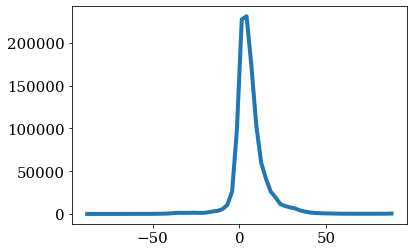

In [203]:
plt.plot(coor.lat,np.mean(MSE_map['AQ+4K']['BF'],axis=(1,2)))

In [305]:
CBAR_position = [0.975, 0.25, 0.02, 0.5]
LABEL = ['(a) Brute Force','(b) Climate Invariant','(c) Cl.Inv.+QM after','(d) Cl.Inv.+QM before']

itype= 0  & modeltype= BF
itype= 1  & modeltype= I
itype= 2  & modeltype= IQM
itype= 3  & modeltype= IO


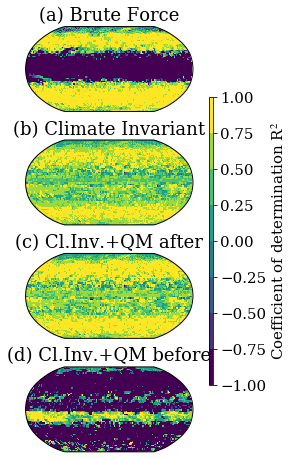

In [308]:
fig, ax = plt.subplots(4,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(3,8))

for itype,modeltype in enumerate(['BF','I','IQM','IO']):
    print ('itype=',itype,' & modeltype=',modeltype)
    toplot = R2_map['AQ+4K'][modeltype]
    imag = ax[itype].pcolormesh(coor.lon,coor.lat,toplot,cmap = cmap_R2, norm = norm_R2, transform=ccrs.PlateCarree())
    ax[itype].set_title(LABEL[itype])
    
    # Colorbar
    if itype==0:
        cbar_ax = fig.add_axes(CBAR_position)
        CBAR = fig.colorbar(imag, label="Coefficient of determination R$^{2}$", cax=cbar_ax)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')


In [128]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

No handles with labels found to put in legend.


itype= 0  & modeltype= IO


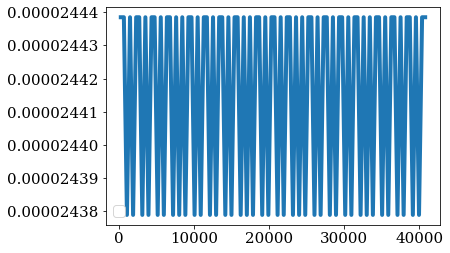

In [286]:
dataset = 'AQ-4K'

#for itype,modeltype in enumerate(['BF','I','IO','IQM']):
for itype,modeltype in enumerate(['IO']):
    print ('itype=',itype,' & modeltype=',modeltype)
#     plt.plot(edg2bin(PDF_map[dataset][modeltype][1]),
#              PDF_map[dataset][modeltype][0],
#              label=modeltype)
    plt.plot(edg2bin(PDF_IO[1]),PDF_IO[0])
#plt.plot(edg2bin(PDF_tru[dataset][1]),PDF_tru[dataset][0],label='Truth',color='k')
#plt.xlim((-100,100))
plt.legend()

In [209]:
pdf_p4K['PERC_array'][:,i0['PHQ']+iout]*scale_dict0[iout]

array([-1014.4715634 ,  -209.26799833,  -160.07971432, ...,
         664.46115479,   790.20536077,  2131.62175702])

itype= 0  & modeltype= BF
itype= 1  & modeltype= I
itype= 2  & modeltype= IO
itype= 3  & modeltype= IQM


/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


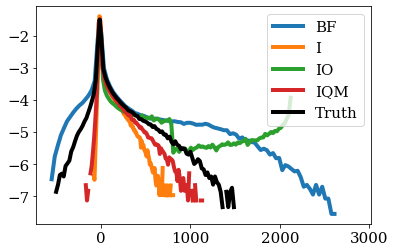

In [211]:
dataset = 'AQ+4K'

for itype,modeltype in enumerate(['BF','I','IO','IQM']):
#for itype,modeltype in enumerate(['IO']):
    print ('itype=',itype,' & modeltype=',modeltype)
    plt.plot(edg2bin(PDF_map[dataset][modeltype][1]),
             np.log10(PDF_map[dataset][modeltype][0]),
             label=modeltype)
plt.plot(edg2bin(PDF_tru[dataset][1]),np.log10(PDF_tru[dataset][0]),label='Truth',color='k')
plt.legend()

## (Legacy code with geographical reformatting) Directly compare NN with and without output rescaling in cold and warm climate to understand how it influences performance & generalization abilities

In [50]:
Nbatches = 5
b_random = np.random.choice(np.linspace(0,5700,5701),size=((Nbatches,)),replace=False).astype('int')

In [51]:
MSE = {}
INP = {}
VAR = {}

In [53]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    MSE[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {};
    
    for itype,modeltype in enumerate(['I','IO']):
        print ('itype=',itype,' & modeltype=',modeltype)
            
        if modeltype=='I':
            model = NN_I
            if dataset=='AQ-4K': train_gen = train_gen_I
            elif dataset=='AQ+4K': train_gen = test_diffclimate_gen_I
            elif dataset=='RG': train_gen = test_diffgeog_gen_I
        elif modeltype=='IO':
            model = NN_IO
            if dataset=='AQ-4K': train_gen = train_gen_IO
            elif dataset=='AQ+4K': train_gen = test_diffclimate_gen_IO
            elif dataset=='RG': train_gen = test_diffgeog_gen_IO
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)

            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
            tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

            mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
            var = np.expand_dims(np.var(prd_geo,axis=2),axis=2)

            if ibatch==0:
                MSE[dataset][modeltype] = mse; 
                VAR[dataset][modeltype] = var; 
                INP[dataset][modeltype] = inp_geo;
            else:
                MSE[dataset][modeltype] = np.concatenate((MSE[dataset][modeltype],mse),axis=2)
                VAR[dataset][modeltype] = np.concatenate((VAR[dataset][modeltype],var),axis=2)
                INP[dataset][modeltype] = np.concatenate((INP[dataset][modeltype],inp_geo),axis=3)

idataset= 0  & dataset= AQ-4K
itype= 0  & modeltype= I
itype= 1  & modeltype= IO
idataset= 1  & dataset= AQ+4K
itype= 0  & modeltype= I
itype= 1  & modeltype= IO


In [54]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    for itype,modeltype in enumerate(['I','IO']):
        print ('itype=',itype,' & modeltype=',modeltype)
        
        print('MSE: mean=',np.mean(MSE[dataset][modeltype],axis=(0,1,2)),
              ', std=',np.std(MSE[dataset][modeltype],axis=(0,1,2)))

idataset= 0  & dataset= AQ-4K
itype= 0  & modeltype= I
MSE: mean= 171.78820248741508 , std= 631.8879569252751
itype= 1  & modeltype= IO
MSE: mean= 0.025037987559114832 , std= 0.016289064515159723
idataset= 1  & dataset= AQ+4K
itype= 0  & modeltype= I
MSE: mean= 556.3014918579623 , std= 2408.551764994274
itype= 1  & modeltype= IO
MSE: mean= 0.04093219379943946 , std= 0.025021671135289338


# Distributional fit for the reciprocal CDF

The goal is to fit CDF$^{-1}$ using a simple parameteric distribution so that we can use it in the loss function. This is equivalent to mapping quantile_array to PERC_array in the "pdf" structure calculated above

In [31]:
pdf

{'2021_03_18_O3_TRAIN_M4K_shuffle.nc': {'quantile_array': array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
  'PERC_array': array([[9.05374009e-07, 8.77815637e-07, 4.98417307e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.11630138e-07, 8.91066577e-07, 5.24233712e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.13556164e-07, 8.93629931e-07, 5.24234508e-07, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.81165069e-06, 1.79016258e-06, 1.61611712e-06, ...,
          4.71056754e-05, 4.42048546e-05, 8.29813011e-05],
         [1.81427470e-06, 1.79245058e-06, 1.62005475e-06, ...,
          6.76648574e-05, 7.45083865e-05, 1.28348825e-04],
         [1.82074757e-06, 1.80071015e-06, 1.63516086e-06, ...,
          5.01840608e-04, 5.79330081e-04, 6.49507623e-04]])},
 '2021_03_18_O3_TRAIN_P4K_shuffle.nc': {'quantile_array': array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
  'PERC_a

In [32]:
m4K = '2021_03_18_O3_TRAIN_M4K_shuffle.nc'

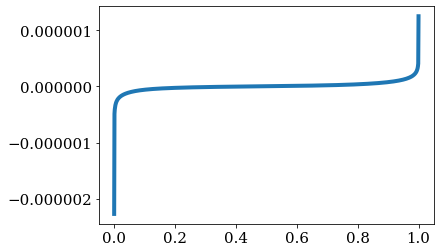

In [37]:
plt.plot(pdf[m4K]['quantile_array'],pdf[m4K]['PERC_array'][:,123])